#**Install Library**

In [15]:
!pip install basemap-data-hires
!pip install seaborn
!pip install basemap numpy pandas scipy
!pip install cartopy

#**Import Library**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import linregress
import datetime
from datetime import datetime
import seaborn as sns


#**Read Dataset**

In [17]:
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset)
df.head(15)

# Konversi kolom 'time' ke format datetime
df['time'] = pd.to_datetime(df['time'])

# Seleksi data hanya untuk tahun 1968 - 2018
df_selected = df[(df['time'].dt.year >= 1968) & (df['time'].dt.year <= 2018)]

# Tampilkan lima baris pertama dari data terpilih
df = df_selected
df.head(5)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1968-01-01 07:50:51.240000+00:00,32.958667,-115.863333,6.0,3.08,ml,5.0,166.0,0.7355,0.29,...,2016-01-28T19:54:48.710Z,"24km WSW of Westmorland, CA",earthquake,1.02,31.61,0.179,5.0,reviewed,ci,ci
1,1968-01-01 11:34:43.790000+00:00,33.468333,-120.179500,6.0,2.59,mh,4.0,302.0,1.0440,0.63,...,2016-01-28T19:37:37.050Z,"53km S of Santa Rosa Is., CA",earthquake,5.56,31.61,0.306,12.0,reviewed,ci,ci
2,1968-01-02 09:50:46.470000+00:00,35.705167,-118.039000,6.0,3.09,ml,8.0,84.0,0.3567,0.71,...,2016-01-28T19:33:22.000Z,"22km WNW of Inyokern, CA",earthquake,1.78,31.61,0.155,11.0,reviewed,ci,ci
3,1968-01-02 11:01:19.830000+00:00,35.740667,-118.060833,6.0,2.88,ml,10.0,97.0,0.3452,0.52,...,2016-01-28T19:59:01.740Z,"25km WNW of Inyokern, CA",earthquake,1.13,31.61,0.167,9.0,reviewed,ci,ci
4,1968-01-04 06:12:39.730000+00:00,35.111000,-119.085833,6.0,2.59,ml,9.0,146.0,0.2834,0.45,...,2016-01-28T19:54:49.210Z,"23km SW of Lamont, CA",earthquake,1.03,31.61,0.136,6.0,reviewed,ci,ci


In [18]:
# Mengambil hanya kolom yang diinginkan
selected_columns = ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'net', 'id', 'updated', 'type', 'status', 'locationSource', 'magSource']
df_selected_columns = df[selected_columns]

# Menampilkan DataFrame yang hanya berisi kolom yang dipilih
df_selected_columns.head(10)

,time,latitude,longitude,depth,mag,magType,net,id,updated,type,status,locationSource,magSource
0,1968-01-01 07:50:51.240000+00:00,32.958667,-115.863333,6.00,3.08,ml,ci,ci3329310,2016-01-28T19:54:48.710Z,earthquake,reviewed,ci,ci
1,1968-01-01 11:34:43.790000+00:00,33.468333,-120.179500,6.00,2.59,mh,ci,ci3342099,2016-01-28T19:37:37.050Z,earthquake,reviewed,ci,ci
2,1968-01-02 09:50:46.470000+00:00,35.705167,-118.039000,6.00,3.09,ml,ci,ci3329312,2016-01-28T19:33:22.000Z,earthquake,reviewed,ci,ci
3,1968-01-02 11:01:19.830000+00:00,35.740667,-118.060833,6.00,2.88,ml,ci,ci3329313,2016-01-28T19:59:01.740Z,earthquake,reviewed,ci,ci
4,1968-01-04 06:12:39.730000+00:00,35.111000,-119.085833,6.00,2.59,ml,ci,ci3329314,2016-01-28T19:54:49.210Z,earthquake,reviewed,ci,ci
5,1968-01-04 06:19:26.850000+00:00,35.118333,-119.099167,6.00,2.37,ml,ci,ci3329315,2016-01-28T19:50:28.820Z,earthquake,reviewed,ci,ci
6,1968-01-04 11:37:09.810000+00:00,32.276000,-117.088833,6.00,3.31,ml,ci,ci3329317,2016-01-28T19:37:37.540Z,earthquake,reviewed,ci,ci
7,1968-01-05 10:50:56.490000+00:00,35.687500,-118.114000,6.00,2.84,ml,ci,ci3329319,2016-01-28T19:41:48.200Z,earthquake,reviewed,ci,ci
8,1968-01-06 00:26:00.650000+00:00,35.089833,-119.059167,5.00,3.01,ml,ci,ci3329320,2016-01-28T19:41:48.730Z,earthquake,reviewed,ci,ci
9,1968-01-09 23:06:13.520000+00:00,34.863833,-118.734833,0.38,2.21,mh,ci,ci3329322,2016-01-28T19:59:02.950Z,earthquake,reviewed,ci,ci


In [19]:
def bvalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()

    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return b*(-1)

def avalue_OLS(magnitude_series):
    magnitudes = magnitude_series.value_counts().sort_index()

    M = magnitudes.index.tolist()
    values = magnitudes.tolist()
    N = np.cumsum(values[::-1])[::-1]
    logN = np.log10(N)
    b,a = np.polyfit(M, logN, 1)
    return a

def generate_GR_Adeli_Panakkat_features(earthquake_dataset, time_window):
    earthquake_dataset['b-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=bvalue_OLS,raw = False).shift(1)
    earthquake_dataset['a-value'] = earthquake_dataset['mag'].rolling(time_window).apply(func=avalue_OLS,raw = False).shift(1)
    earthquake_dataset['Max magnitude expected'] = earthquake_dataset['a-value']/earthquake_dataset['b-value']

    return earthquake_dataset

In [20]:
california_region = df[df.mag >= 4.0].reset_index(drop = True)

In [21]:
california_region = generate_GR_Adeli_Panakkat_features(california_region, 50)

In [22]:
california_region.tail()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,horizontalError,depthError,magError,magNst,status,locationSource,magSource,b-value,a-value,Max magnitude expected
1310,2018-08-29 02:33:28.330000+00:00,34.136333,-117.774667,5.46,4.38,mw,208.0,16.0,0.03385,0.26,...,0.11,0.48,NaN,6.0,reviewed,ci,ci,1.257576,6.701348,5.328783
1311,2018-09-29 02:17:46.720000+00:00,32.347667,-115.184000,28.67,4.41,mw,34.0,172.0,0.10180,0.29,...,0.74,0.41,NaN,6.0,reviewed,ci,ci,1.265668,6.744524,5.328827
1312,2018-11-19 20:18:42.510000+00:00,32.206500,-115.253500,10.95,4.82,mw,29.0,149.0,0.21680,0.38,...,0.79,31.61,NaN,6.0,reviewed,ci,ci,1.272071,6.783193,5.332402
1313,2018-11-27 13:07:12.830000+00:00,36.073500,-120.188167,10.80,4.00,mw,92.0,51.0,0.06483,0.11,...,0.18,0.32,NaN,5.0,reviewed,nc,nc,1.268823,6.769767,5.335469
1314,2018-12-05 21:40:16.620000+00:00,35.730333,-117.077667,0.84,4.20,mw,60.0,34.0,0.23160,0.17,...,0.13,0.61,NaN,6.0,reviewed,ci,ci,1.256775,6.710128,5.339164


#**Variasi Temporal nilai b**

In [23]:
df = california_region
# Mengonversi kolom 'time' ke tipe data datetime
df['time'] = pd.to_datetime(df['time'])

# Menambahkan kolom 'year' yang berisi tahun dari kolom 'time'
df['year'] = df['time'].dt.year

# Menampilkan lima baris pertama DataFrame
df.head(5)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,b-value,a-value,Max magnitude expected,year
0,1968-03-28 21:21:33+00:00,34.046167,-116.080333,6.0,4.13,ml,14.0,157.0,0.4991,0.62,...,31.61,0.081,11.0,reviewed,ci,ci,NaN,NaN,NaN,1968
1,1968-04-09 02:28:59.610000+00:00,33.179833,-116.103000,10.0,6.60,mw,15.0,128.0,0.6012,0.33,...,31.61,NaN,0.0,reviewed,ci,ci,NaN,NaN,NaN,1968
2,1968-04-09 02:33:09+00:00,33.166667,-116.116667,0.0,4.30,mh,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,reviewed,ci,ci,NaN,NaN,NaN,1968
3,1968-04-09 02:39:28.520000+00:00,33.166667,-116.116667,6.0,4.23,ml,3.0,178.0,0.6020,2.26,...,31.61,0.128,8.0,reviewed,ci,ci,NaN,NaN,NaN,1968
4,1968-04-09 03:03:51.090000+00:00,32.874667,-116.150167,6.0,5.20,mh,3.0,229.0,0.5117,0.33,...,31.61,NaN,0.0,reviewed,ci,ci,NaN,NaN,NaN,1968


In [27]:
#reduksi kolom
fixkolom = california_region[['time','latitude', 'longitude', 'depth', 'mag','magType','year','a-value','b-value']]
fixkolom.head(10)

,time,latitude,longitude,depth,mag,magType,year,a-value,b-value
0,1968-03-28 21:21:33+00:00,34.046167,-116.080333,6.0,4.13,ml,1968,NaN,NaN
1,1968-04-09 02:28:59.610000+00:00,33.179833,-116.103000,10.0,6.60,mw,1968,NaN,NaN
2,1968-04-09 02:33:09+00:00,33.166667,-116.116667,0.0,4.30,mh,1968,NaN,NaN
3,1968-04-09 02:39:28.520000+00:00,33.166667,-116.116667,6.0,4.23,ml,1968,NaN,NaN
4,1968-04-09 03:03:51.090000+00:00,32.874667,-116.150167,6.0,5.20,mh,1968,NaN,NaN
5,1968-04-09 03:48:11.390000+00:00,33.068667,-116.025333,6.0,4.54,ml,1968,NaN,NaN
6,1968-04-09 03:58:36.060000+00:00,33.013333,-115.978833,6.0,4.14,ml,1968,NaN,NaN
7,1968-04-09 08:00:38.240000+00:00,32.998667,-115.980833,6.0,4.08,ml,1968,NaN,NaN
8,1968-04-09 18:31:04.210000+00:00,33.296333,-116.291500,14.0,4.45,ml,1968,NaN,NaN
9,1968-04-14 12:55:59.500000+00:00,33.229167,-116.218167,11.0,4.33,ml,1968,NaN,NaN


In [28]:
fixkolom = fixkolom.dropna()
fixkolom

,time,latitude,longitude,depth,mag,magType,year,a-value,b-value
50,1971-02-09 14:04:35.980000+00:00,34.416000,-118.370000,6.00,4.20,mh,1971,4.060424,0.611916
51,1971-02-09 14:04:37.640000+00:00,34.416000,-118.370000,6.00,4.10,mh,1971,4.057577,0.611353
52,1971-02-09 14:04:42.340000+00:00,34.416000,-118.370000,6.00,4.20,mh,1971,4.440794,0.703422
53,1971-02-09 14:04:44.080000+00:00,34.416000,-118.370000,6.00,4.10,mh,1971,4.429935,0.701460
54,1971-02-09 14:04:46+00:00,34.411167,-118.400667,6.00,4.20,mh,1971,4.415478,0.698739
...,...,...,...,...,...,...,...,...,...
1310,2018-08-29 02:33:28.330000+00:00,34.136333,-117.774667,5.46,4.38,mw,2018,6.701348,1.257576
1311,2018-09-29 02:17:46.720000+00:00,32.347667,-115.184000,28.67,4.41,mw,2018,6.744524,1.265668
1312,2018-11-19 20:18:42.510000+00:00,32.206500,-115.253500,10.95,4.82,mw,2018,6.783193,1.272071
1313,2018-11-27 13:07:12.830000+00:00,36.073500,-120.188167,10.80,4.00,mw,2018,6.769767,1.268823


In [29]:
# Groupby & multiple aggregations
result = fixkolom.groupby('year')['a-value'].aggregate(['mean','min','max','sum'])

print(result)

          mean       min       max         sum
year                                          
1971  4.470355  4.057577  5.870731  192.225279
1972  5.786018  5.775886  5.790839   23.144071
1973  6.079362  5.445464  7.314055   72.952344
1974  5.700453  5.375618  5.926098   91.207242
1975  6.159223  5.575310  7.113677  246.368904
1976  6.563175  6.409564  6.846526  124.700325
1977  6.523342  6.478230  6.573460   32.616708
1978  6.640166  6.456485  6.811110   79.681990
1979  5.299945  4.692136  6.561746  217.297743
1980  4.493223  4.360775  4.706392   35.945783
1981  4.339604  4.253821  4.447698   56.414851
1982  4.603742  4.265046  4.779370  105.886073
1983  4.326099  4.006581  4.635273  203.326665
1984  5.132821  4.358533  5.875391   76.992314
1985  5.735633  5.440095  5.929705   97.505754
1986  5.208687  4.974865  5.727560  109.382425
1987  4.437834  4.026925  5.130703  155.324182
1988  4.251970  4.180312  4.324410   63.779551
1989  4.436957  4.327214  4.518935   70.991312
1990  5.57485

In [31]:
a_tot = fixkolom.groupby("year")["a-value"].sum()

a_ave = result["sum"].mean()

#**Temporal variation using values-a**

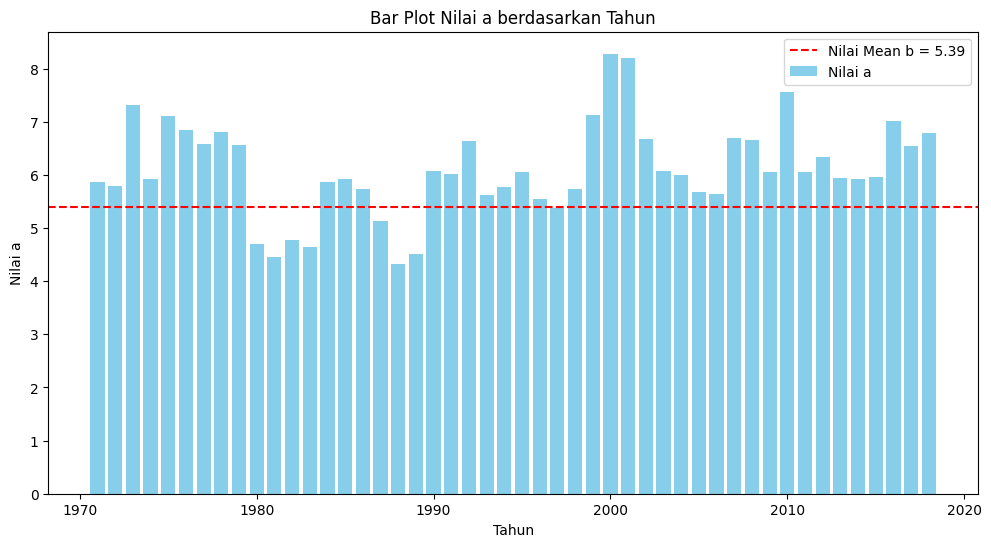

In [32]:
filtered_data = fixkolom[(fixkolom['year'] >= 1968) & (fixkolom['year'] <= 2018)]

# Hitung nilai mean dari b-value
mean_a_value = filtered_data['a-value'].mean()

# Plot bar plot
plt.figure(figsize=(12, 6))
plt.bar(filtered_data['year'], filtered_data['a-value'], color='skyblue', label='Nilai a')
plt.axhline(y=mean_a_value, color='red', linestyle='--', label=f'Nilai Mean b = {mean_a_value:.2f}')
plt.xlabel('Tahun')
plt.ylabel('Nilai a')
plt.title('Bar Plot Nilai a berdasarkan Tahun')
plt.legend()
plt.show()
